In [1]:
import os
import random
import numpy as np
from collections import defaultdict
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit

from prepro_script import *  # Imports convert_to_suv, generate_mip, preprocess_pet_series, etc.

# reproducibility
random.seed(42)
np.random.seed(42)


def binarize_deauville(score):
    try:
        s = float(score)
    except:
        return None
    return 0 if s <= 3 else 1 if s >= 4 else None


#############################################
# 1. Load and filter mapping by localization frequency
#############################################
mapping_excel_path = r"/home/mezher/Documents/Deauville_DeepLearning/splitting/1. DeepDeauville Excel complété et anonymisé.xlsx"
df_mapping_full = pd.read_excel(mapping_excel_path)

# compute how often each localization appears
loc_counts = df_mapping_full['Lesion localisation '].value_counts()
# keep only those with >= 38 occurrences
kept_locs = loc_counts[loc_counts >= 19].index
df_mapping = df_mapping_full[df_mapping_full['Lesion localisation '].isin(kept_locs)].copy()

# now build your dicts only from the filtered mapping
study_to_pid          = dict(zip(df_mapping['SubjectCode'], df_mapping['PID']))
study_to_target       = {
    study: binarize_deauville(score)
    for study, score in zip(df_mapping['SubjectCode'], df_mapping['Deauville score '])
}
study_to_localization = dict(zip(df_mapping['SubjectCode'], df_mapping['Lesion localisation ']))

# set of valid study IDs for quick lookup
valid_studies = set(study_to_pid.keys())

In [2]:
import pandas as pd

# 1) Load your image index
df_img = pd.read_csv("/home/mezher/Documents/Deauville_DeepLearning/splitting/data.csv")   # or whatever path points to data.csv
# it has columns: patient_id, study_id, scan_id, filename, …, splits…

# 2) Load your Excel mapping
mapping_excel_path = (
    "/home/mezher/Documents/Deauville_DeepLearning/"
    "splitting/1. DeepDeauville Excel complété et anonymisé.xlsx"
)
df_map = pd.read_excel(mapping_excel_path)

# 3) Inner‐join to keep only studies with images
df_common = pd.merge(
    df_map,
    df_img[['study_id']].drop_duplicates(),
    left_on="SubjectCode",
    right_on="study_id",
    how="inner"
)
print(f"Dropped {df_map['SubjectCode'].nunique() - df_common['SubjectCode'].nunique()} Excel studies with no images\n")

# 4) Run your descriptive stats on df_common:
print("=== Summary ===")
print(f"Unique patients: {df_common['PID'].nunique()}")
print(f"Unique studies : {df_common['SubjectCode'].nunique()}")
print(f"Mean age       : {df_common['Age Exam'].mean():.1f} ± {df_common['Age Exam'].std():.1f}\n")

print("=== Sex distribution ===")
print(df_common['Sexe'].value_counts(), "\n")

print("=== Deauville scores ===")
print(df_common['Deauville score '].value_counts().sort_index(), "\n")

print("=== Lesion localizations (≥19) ===")
locs = df_common['Lesion localisation '].value_counts()
print(locs[locs>=19], "\n")

print("=== Weight & height ===")
print(f"Poids Kg: {df_common['Poids Kg'].mean():.1f} ± {df_common['Poids Kg'].std():.1f}")
print(f"Taille Cm: {df_common['Taille Cm'].mean():.1f} ± {df_common['Taille Cm'].std():.1f}\n")

print("=== SUV metrics & uptake time ===")
for col in ['Lesion SUVmax', 'Liver SUVmax', 'Bloodpool SUVmax', 'Uptake time (min)']:
    s = df_common[col].dropna()
    print(f"{col}: {s.mean():.2f} ± {s.std():.2f}  (min {s.min():.2f}, max {s.max():.2f})")

print("\n=== Line of Treatment ===")
print(df_common['Line of treatment '].value_counts(), "\n")

print("=== Actual Problem ===")
print(df_common['Actual problem'].value_counts(), "\n")




Dropped 197 Excel studies with no images

=== Summary ===
Unique patients: 882
Unique studies : 1602
Mean age       : 53.3 ± 18.3

=== Sex distribution ===
Sexe
H    944
F    658
Name: count, dtype: int64 

=== Deauville scores ===
Deauville score 
1    896
2    121
3    252
4    102
5    231
Name: count, dtype: int64 

=== Lesion localizations (≥19) ===
Lesion localisation 
51.0    896
9.0     134
28.0     77
10.0     71
6.0      59
20.0     57
11.0     55
5.0      51
8.0      40
1.0      38
2.0      38
7.0      30
25.0     19
27.0     19
Name: count, dtype: int64 

=== Weight & height ===
Poids Kg: 72.7 ± 17.1
Taille Cm: 169.1 ± 15.3

=== SUV metrics & uptake time ===
Lesion SUVmax: 2.91 ± 5.18  (min 0.00, max 46.51)
Liver SUVmax: 3.40 ± 0.63  (min 1.69, max 5.89)
Bloodpool SUVmax: 2.40 ± 0.46  (min 0.87, max 3.80)
Uptake time (min): 60.67 ± 2.80  (min 0.00, max 74.00)

=== Line of Treatment ===
Line of treatment 
1    981
3    337
2    284
Name: count, dtype: int64 

=== Actual Prob

In [3]:


#############################################
# 2. Functions to load PET series and study data
#############################################

def load_pet_series(modality_path):
    """
    Load all PET DICOM files from a series folder, group them by SeriesInstanceUID,
    sort by InstanceNumber, and stack them into a 3D NumPy array.
    """
    series_dict = defaultdict(list)
    
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    for fname in os.listdir(modality_path):
        fpath = os.path.join(modality_path, fname)
        if not os.path.isfile(fpath):
            continue
        try:
            ds = pydicom.dcmread(fpath)
            # ensure TransferSyntaxUID
            if not hasattr(ds, "file_meta"):
                ds.file_meta = pydicom.dataset.FileMetaDataset()
            if not hasattr(ds.file_meta, "TransferSyntaxUID"):
                ds.file_meta.TransferSyntaxUID = "1.2.840.10008.1.2.1"
            
            series_id = ds.get("SeriesInstanceUID", None)
            if series_id:
                series_dict[series_id].append(ds)
        except Exception as e:
            print(f"❌ ERROR reading {fpath}: {e}")
    
    volumes = {}
    for sid, slices in series_dict.items():
        slices.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            vol = np.stack([s.pixel_array for s in slices])
            volumes[sid] = {"volume": vol, "metadata_list": slices}
        except Exception as e:
            print(f"❌ ERROR stacking series {sid}: {e}")
    return volumes


def load_all_studies_data(data_dir, valid_studies, modality_prefix="PT"):
    """
    Load PET data only for studies in valid_studies.
    """
    all_data = {}
    for study_folder in os.listdir(data_dir):
        # skip anything not in our filtered mapping
        if study_folder not in valid_studies:
            continue
        
        study_path = os.path.join(data_dir, study_folder)
        if not os.path.isdir(study_path) or not study_folder.startswith("DeepDeauville"):
            continue
        
        print(f"Processing study folder: {study_folder}")
        series_folder_found = False
        
        for sub in os.listdir(study_path):
            if not sub.startswith(modality_prefix):
                continue
            subpath = os.path.join(study_path, sub)
            if not os.path.isdir(subpath):
                continue
            
            series = load_pet_series(subpath)
            if series:
                all_data[study_folder] = series
                series_folder_found = True
            else:
                print(f"❌ No valid series in {subpath}")
            break  # assume one PET series per study
        
        if not series_folder_found:
            print(f"❌ No series folder starting with '{modality_prefix}' in {study_folder}")
    
    return all_data



#############################################
# 3. Load and reorganize by patient
#############################################
# after you build valid_studies = set(study_to_pid.keys())
data_dir = r"/home/mezher/Documents/Deauville_DeepLearning/PET"
all_study_data = load_all_studies_data(data_dir, valid_studies, modality_prefix="PT")


# group by patient
all_patient_data = {}
for study_id, series_data in all_study_data.items():
    pid = study_to_pid.get(study_id)
    if pid is None:
        print(f"Warning: Study {study_id} missing in mapping (shouldn't happen).")
        continue
    all_patient_data.setdefault(pid, {})[study_id] = series_data



Processing study folder: DeepDeauville 1378
Processing study folder: DeepDeauville 1367
Processing study folder: DeepDeauville 0432
Processing study folder: DeepDeauville 1687
Processing study folder: DeepDeauville 1332
Processing study folder: DeepDeauville 0370
Processing study folder: DeepDeauville 1503
Processing study folder: DeepDeauville 0747
Processing study folder: DeepDeauville 0083
Processing study folder: DeepDeauville 0371
Processing study folder: DeepDeauville 1456
Processing study folder: DeepDeauville 1240
Processing study folder: DeepDeauville 1704
Processing study folder: DeepDeauville 1790
Processing study folder: DeepDeauville 0339
Processing study folder: DeepDeauville 1496
Processing study folder: DeepDeauville 0315
Processing study folder: DeepDeauville 1783
Processing study folder: DeepDeauville 0004
Processing study folder: DeepDeauville 0999
Processing study folder: DeepDeauville 0930
Processing study folder: DeepDeauville 0247
Processing study folder: DeepDea

--- Sexe ---
Train: Sexe
H    0.588324
F    0.411676
Name: proportion, dtype: float64
Test:  Sexe
H    0.588235
F    0.411765
Name: proportion, dtype: float64

--- AgeGroup ---
Train: AgeGroup
60-74    0.278999
45-59    0.232752
30-44    0.221380
75+      0.141774
<30      0.125095
Name: proportion, dtype: float64
Test:  AgeGroup
60-74    0.287197
45-59    0.273356
30-44    0.211073
<30      0.114187
75+      0.114187
Name: proportion, dtype: float64

--- Deauville_binary ---
Train: Deauville_binary
0    0.783927
1    0.216073
Name: proportion, dtype: float64
Test:  Deauville_binary
0    0.83045
1    0.16955
Name: proportion, dtype: float64

--- Deauville score  ---
Train: Deauville score 
1    0.553450
3    0.158453
5    0.147081
2    0.072024
4    0.068992
Name: proportion, dtype: float64
Test:  Deauville score 
1    0.584775
3    0.155709
5    0.131488
2    0.089965
4    0.038062
Name: proportion, dtype: float64

--- Line of treatment  ---
Train: Line of treatment 
1    0.615618
3  

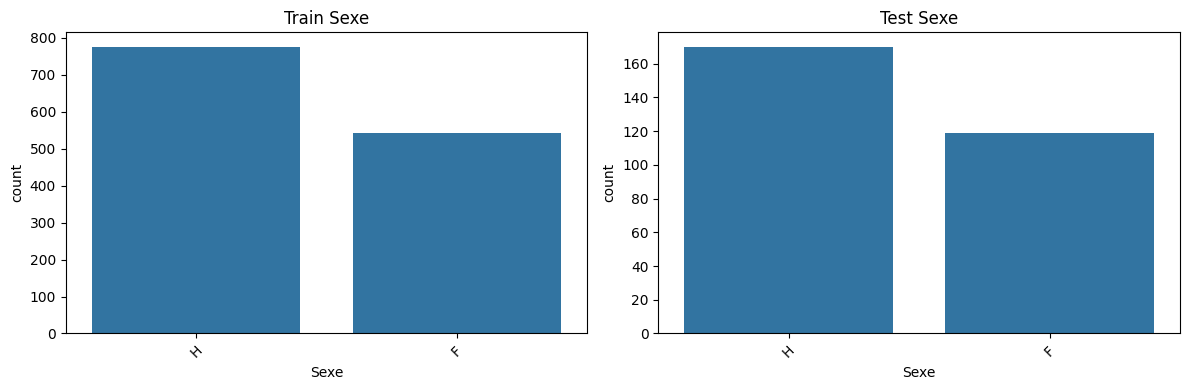

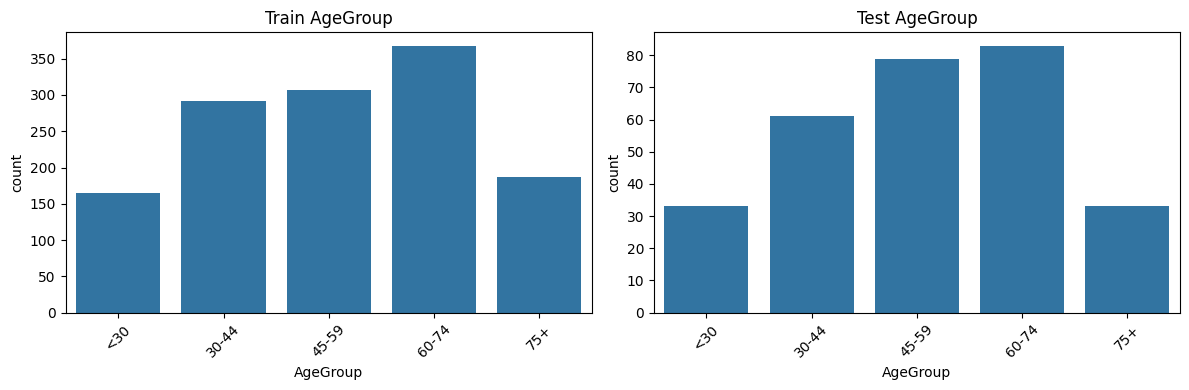

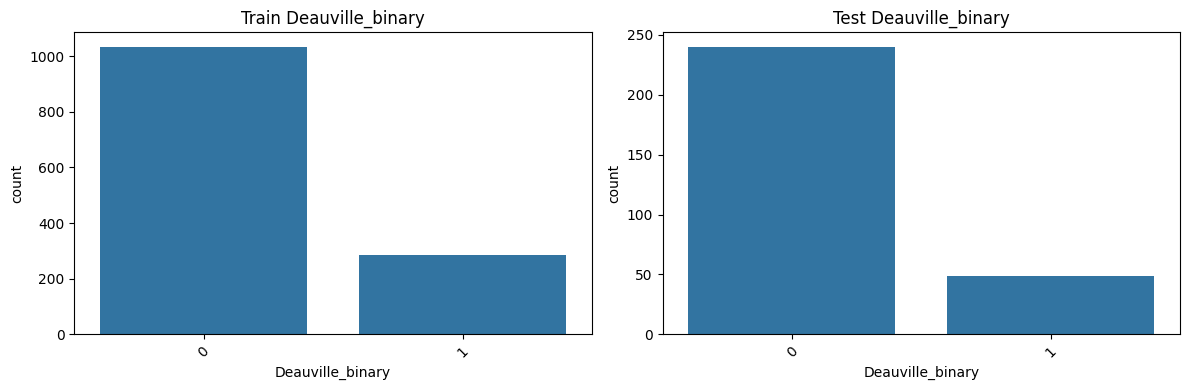

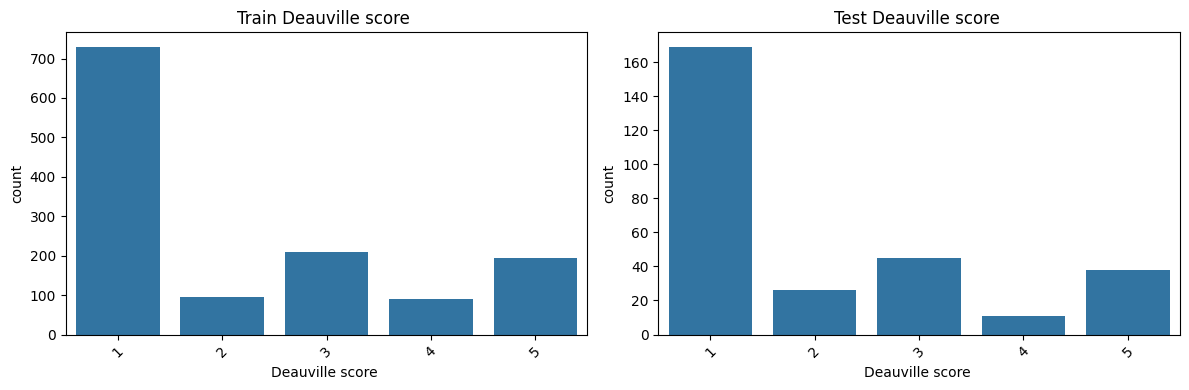

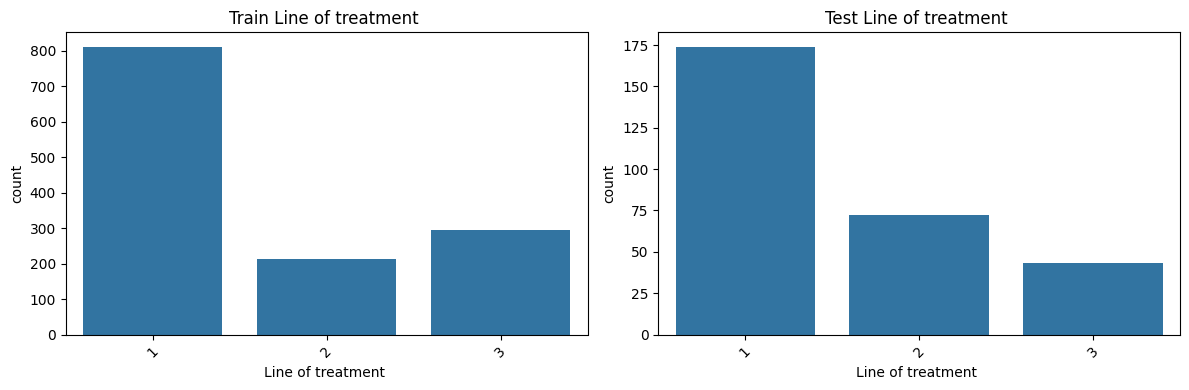

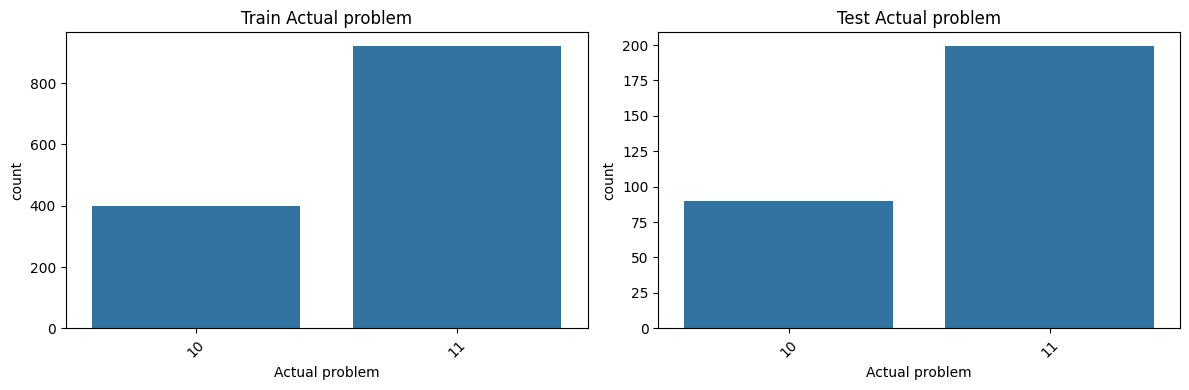

In [ ]:


#############################################
# 4. Patient‑level splitting
#############################################
patient_ids = list(all_patient_data.keys())
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
train_idx, test_idx = next(gss.split(patient_ids, groups=patient_ids))
train_pids = [patient_ids[i] for i in train_idx]
test_pids  = [patient_ids[i] for i in test_idx]

train_data = {pid: all_patient_data[pid] for pid in train_pids}
test_data  = {pid: all_patient_data[pid] for pid in test_pids}


#############################################
# 5. Build train/test DataFrames and visualize
#############################################
train_df = df_mapping[df_mapping['PID'].isin(train_pids)].copy()
test_df  = df_mapping[df_mapping['PID'].isin(test_pids)].copy()

train_df['Deauville_binary'] = train_df['Deauville score '].apply(binarize_deauville)
test_df ['Deauville_binary'] = test_df ['Deauville score '].apply(binarize_deauville)

bins   = [0,30,45,60,75,120]
labels = ['<30','30-44','45-59','60-74','75+']
train_df['AgeGroup'] = pd.cut(train_df['Age Exam'], bins=bins, labels=labels, right=False)
test_df ['AgeGroup'] = pd.cut(test_df ['Age Exam'], bins=bins, labels=labels, right=False)

strat_cols = ["Sexe","AgeGroup","Deauville_binary","Deauville score ","Line of treatment ","Actual problem"]

for col in strat_cols:
    print(f"--- {col} ---")
    print("Train:", train_df[col].value_counts(normalize=True))
    print("Test: ", test_df[col].value_counts(normalize=True))
    print()

# side‑by‑side countplots
for col in strat_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.countplot(x=col,data=train_df)
    plt.title("Train "+col)
    plt.xticks(rotation=45)
    plt.subplot(1,2,2)
    sns.countplot(x=col,data=test_df)
    plt.title("Test "+col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [5]:
import random
all_scan_list = []
global_scan_id = 0
num_splits = 20  # Number of bootstrap splits

# Pre-compute bootstrap splits at the patient level for training data.
# Each patient will have a consistent bootstrap assignment across all their studies.
bootstrap_splits_by_patient = {
    pid: {f"split{split}": ("train" if random.random() < 0.8 else "val") for split in range(num_splits)}
    for pid in train_pids
}

# Process training data using the patient-level bootstrap assignments
for pid, studies in train_data.items():
    # Retrieve the pre-computed bootstrap splits for this patient.
    bootstrap_splits = bootstrap_splits_by_patient[pid]
    for study_id, series_dict in studies.items():
        # Extract target values from the mapping.
        target = study_to_target.get(study_id, None)
        target_loc = study_to_localization.get(study_id, None)
        for series_uid, series_data in series_dict.items():
            processed_images = preprocess_pet_series(series_data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            filename_coronal = f"{study_id}_cor.npy"
            filename_sagittal = f"{study_id}_sag.npy"
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            np.save(os.path.join(image_dir, filename_coronal), mip_coronal.astype(np.float32))
            np.save(os.path.join(image_dir, filename_sagittal), mip_sagittal.astype(np.float32))
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(mip_coronal.shape[0], mip_coronal.shape[1]),
                 (mip_sagittal.shape[0], mip_sagittal.shape[1])]
            ):
                row = {
                    "patient_id": pid,
                    "study_id": study_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1],
                    "target": target,
                    "target_loc": target_loc
                }
                # Use the patient-level bootstrap splits for each row.
                row.update(bootstrap_splits)
                all_scan_list.append(row)
            global_scan_id += 1

# Process test data (all splits set to "test")
for pid, studies in test_data.items():
    for study_id, series_dict in studies.items():
        target = study_to_target.get(study_id, None)
        target_loc = study_to_localization.get(study_id, None)
        for series_uid, series_data in series_dict.items():
            processed_images = preprocess_pet_series(series_data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            bootstrap_splits = {f"split{split}": "test" for split in range(num_splits)}
            filename_coronal = f"{study_id}_cor.npy"
            filename_sagittal = f"{study_id}_sag.npy"
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            np.save(os.path.join(image_dir, filename_coronal), mip_coronal.astype(np.float32))
            np.save(os.path.join(image_dir, filename_sagittal), mip_sagittal.astype(np.float32))
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(mip_coronal.shape[0], mip_coronal.shape[1]),
                 (mip_sagittal.shape[0], mip_sagittal.shape[1])]
            ):
                row = {
                    "patient_id": pid,
                    "study_id": study_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1],
                    "target": target,
                    "target_loc": target_loc
                }
                row.update(bootstrap_splits)
                all_scan_list.append(row)
            global_scan_id += 1

df_final = pd.DataFrame(all_scan_list)
print(df_final.head())
df_final.to_csv("data.csv", index=False)


---- SUV Conversion Debug Info ----
Max Rescale Slope  : 7.56748
Mean Rescale Slope : 0.788965702341137
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 353740000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2021-10-04 09:10:00
Series Time: 2021-10-04 10:11:12
Patient Weight (kg): 92.0
Decay Correction Factor: 0.6794647615638233
Max activity concentration (Bq/ml): 247963.61716
Corrected Dose (Bq): 240353864.75558686
Max SUV value calculated: 94.91277705027929
------------------------------------
SUV volume shape before resampling: (299, 192, 192)
Original Spacing: (2.734375, 2.734375, 3.27)
Original Size: (192, 192, 299)
New Spacing: [3.27, 3.27, 3.27]
Computed New Size: [161, 161, 299]
Resampled SUV Volume shape: (299, 161, 161)
Final SUV Volume shape after optional cropping: (299, 161, 161)
---- SUV Conversion Debug Info ----
Max Rescale Slope  : 5.26957
Mean Rescale Slope : 0.5175839791122716
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 258690000

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and label each row as train/test ---
df = pd.read_csv("data.csv")   # ← adjust this path if needed
df['set'] = df['split0'].apply(lambda x: 'test' if x=='test' else 'train')

# --- 2. Print overall counts per set ---
summary = df.groupby('set').agg(
    images   = ('scan_id',   'count'),
    patients = ('patient_id','nunique'),
    studies  = ('study_id',  'nunique'),
)
print("Overall counts by set:\n", summary, "\n")



Overall counts by set:
        images  patients  studies
set                             
test      578       177      289
train    2626       705     1313 



In [8]:
# Identify all the split columns
split_cols = [c for c in df.columns if c.startswith("split")]

# Compute value counts _as proportions_ for each split
proportions = (
    df[split_cols]
    .apply(lambda col: col.value_counts(normalize=True))
    .T
    .fillna(0)
)

# Display the proportions table
print(proportions)

           test     train       val
split0   0.1804  0.648564  0.171036
split1   0.1804  0.659800  0.159800
split2   0.1804  0.661049  0.158552
split3   0.1804  0.675406  0.144195
split4   0.1804  0.657303  0.162297
split5   0.1804  0.658552  0.161049
split6   0.1804  0.658552  0.161049
split7   0.1804  0.665418  0.154182
split8   0.1804  0.665418  0.154182
split9   0.1804  0.642322  0.177278
split10  0.1804  0.639201  0.180400
split11  0.1804  0.681648  0.137953
split12  0.1804  0.654182  0.165418
split13  0.1804  0.646692  0.172909
split14  0.1804  0.674782  0.144819
split15  0.1804  0.654182  0.165418
split16  0.1804  0.651061  0.168539
split17  0.1804  0.663546  0.156055
split18  0.1804  0.667291  0.152310
split19  0.1804  0.648564  0.171036


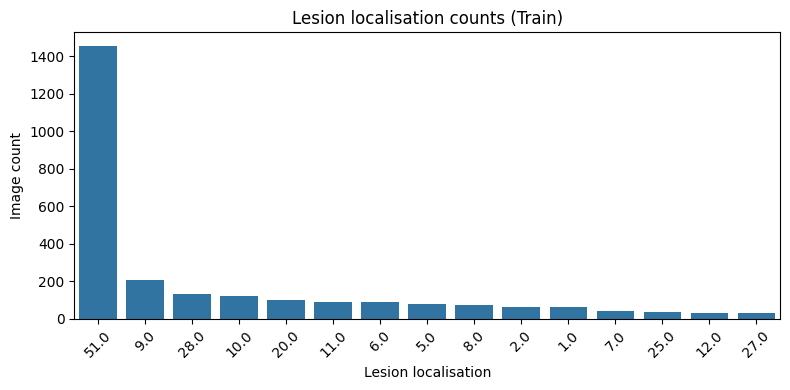

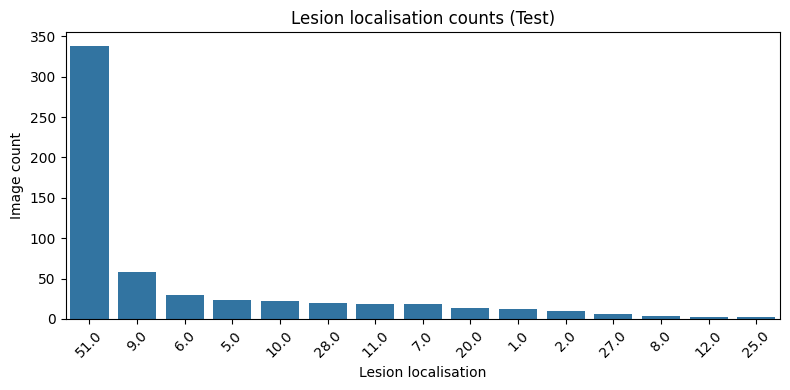

In [7]:
# --- 3. Plot lesion‑localization counts in TWO separate figures, ordered by frequency ---
for subset in ['train','test']:
    sub = df[df['set']==subset]
    # count and sort descending
    counts = sub['target_loc'].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(8,4))
    sns.barplot(
        x=counts.index,
        y=counts.values,
        order=counts.index,         # ensures bars are plotted in this order
    )
    plt.title(f"Lesion localisation counts ({subset.capitalize()})")
    plt.xlabel("Lesion localisation")
    plt.ylabel("Image count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Selected files: ['DeepDeauville 0476_sag.npy', 'DeepDeauville 0706_sag.npy', 'DeepDeauville 0359_cor.npy', 'DeepDeauville 0114_sag.npy', 'DeepDeauville 1047_cor.npy', 'DeepDeauville 0724_cor.npy', 'DeepDeauville 0625_sag.npy', 'DeepDeauville 0340_sag.npy', 'DeepDeauville 0451_cor.npy', 'DeepDeauville 1520_sag.npy']


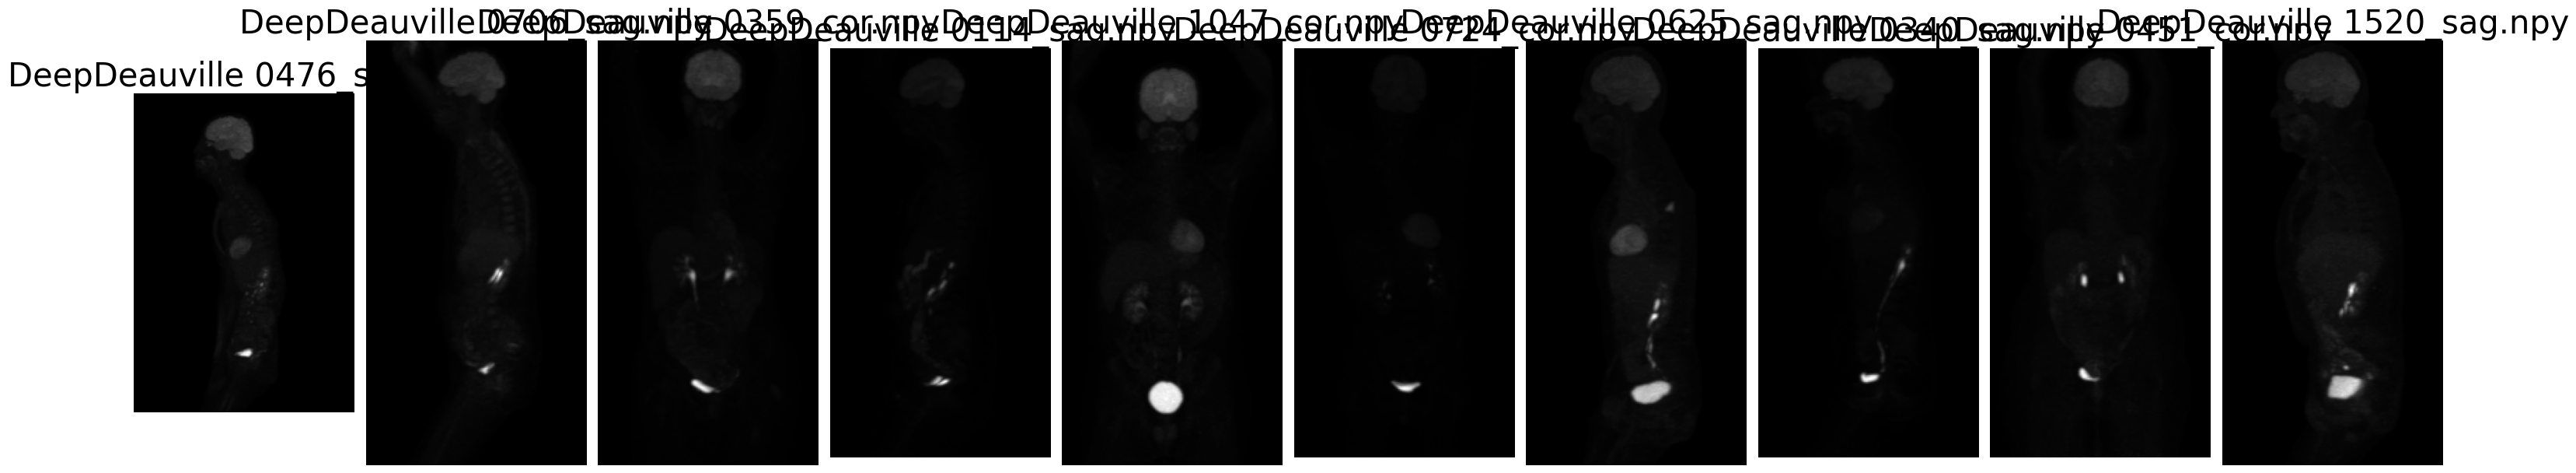

In [4]:

import os
# Define the images folder (adjust if necessary)
images_dir = os.path.join(os.getcwd(), "images")

# List all .npy files in the folder
image_files = [f for f in os.listdir(images_dir) if f.endswith('.npy')]

# Randomly select 5 images (if there are fewer than 5, select all)
selected_files = random.sample(image_files, min(10, len(image_files)))
print("Selected files:", selected_files)

# Plot the selected images in a row
fig, axes = plt.subplots(1, len(selected_files), figsize=(30, 10))
for ax, file in zip(axes, selected_files):
    img = np.load(os.path.join(images_dir, file))
    ax.imshow(img, cmap='gray')
    ax.set_title(file, fontsize=30)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
import os

dir1 = "/home/mezher/Documents/Deauville_DeepLearning/splitting/images"
dir2 = "/home/mezher/Documents/Deauville_DeepLearning/splitting/images0"

# count only .npy files (or adjust the extension to whatever your images are)
count1 = len([f for f in os.listdir(dir1) if f.endswith('.npy')])
count2 = len([f for f in os.listdir(dir2) if f.endswith('.npy')])

print(f"{dir1!r} contains {count1} images")
print(f"{dir2!r} contains {count2} images")


'/home/mezher/Documents/Deauville_DeepLearning/splitting/images' contains 3204 images
'/home/mezher/Documents/Deauville_DeepLearning/splitting/images0' contains 3574 images
